# Using TopOMetry for document embedding

This tutorial reproduces an UMAP example on the [20 newsgroups dataset](http://qwone.com/~jason/20Newsgroups/) for document embedding, and compares its results to those of TopOMetry models. The 20 newsgroups dataset is a collection of forum posts, labelled by topic. The task here is to represent this high-dimensional information in a comprehensive visualization in which news within the same topic end up close together, and different topics get separated from each other. By the end of this tutorial, we'll see TopOMetry recoveries a lot of substructure that was missed by using UMAP alone. This happens because TopOMetry's models extract latent information before learning a new topological graph which is may be embedded with UMAP.

Load required libraries:

In [1]:
import numpy as np
import pandas as pd

# For comparison
import umap
import topo as tp

# Used to get the data
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

# Some plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline

2023-06-04 13:41:06.086515: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 13:41:06.744927: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Download data:

In [2]:
dataset = fetch_20newsgroups(subset='all',
                             shuffle=True, random_state=42)

In [3]:
print(f'{len(dataset.data)} documents')
print(f'{len(dataset.target_names)} categories')

18846 documents
20 categories


This data contains 18846 documents spanning 20 categories. These categories are:

In [4]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

 We can print some of our news to get an idea of what we're dealing with.

In [5]:
for idx, document in enumerate(dataset.data[:3]):
    category = dataset.target_names[dataset.target[idx]]

    print(f'Category: {category}')
    print('---------------------------')
    # Print the first 500 characters of the post
    print(document[:500])
    print('---------------------------')

Category: rec.sport.hockey
---------------------------
From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killin
---------------------------
Category: comp.sys.ibm.pc.hardware
---------------------------
From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)
Subject: Which high-performance VLB video card?
Summary: Seek recommendations for VLB video card
Nntp-Posting-Host: midway.ecn.uoknor.edu
Organization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA
Keywords: orchid, stealth, vlb
Lines: 21

  My brother is in the market for

In [6]:
category_labels = [dataset.target_names[x] for x in dataset.target]
hover_df = pd.DataFrame(category_labels, columns=['category'])

#### Representing texts as a matrix

Here, we'll use the [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) approach. For this, we'll count how many times each word appeared in each document, and create a matrix of word frequency per document. This will allow us to quantitatively represent these texts. Such task is done using scikit-learn CountVectorizer. 

In [7]:
vectorizer = CountVectorizer(min_df=5, stop_words='english')
word_doc_matrix = vectorizer.fit_transform(dataset.data)

 Next, we feed this matrix to UMAP.

In [8]:
umap_embedding = umap.UMAP(n_components=2, metric='hellinger').fit(word_doc_matrix)

And define a plotting function to handle the categories names and colors for us:

In [9]:
def plot_20k_newsgroups(embedding, figsize=(8,8)):
    from matplotlib.patches import Patch
    unique_labels = np.unique(hover_df['category'])
    num_labels = unique_labels.shape[0]
    color_key = plt.get_cmap("Spectral")(np.linspace(0, 1, num_labels))
    legend_elements = [
        Patch(facecolor=color_key[i], label=unique_labels[i])
        for i, k in enumerate(unique_labels)
    ]
    f, ax = plt.subplots(figsize=(8,8))
    ax.scatter(embedding[:, 0], embedding[:, 1], c=dataset.target, cmap='Spectral', s=0.5)
    ax.legend(handles=legend_elements)
    ax.set_xticks(())
    ax.set_yticks(())

And finally visualize the UMAP embedding:

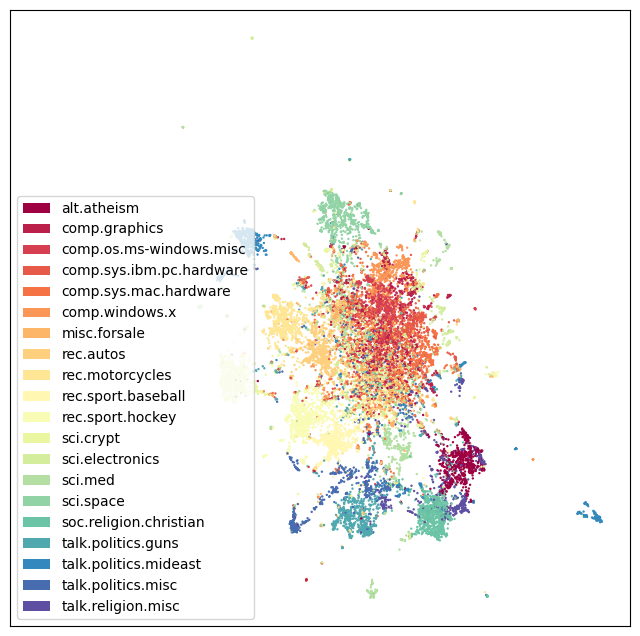

In [10]:
plot_20k_newsgroups(umap_embedding.embedding_, figsize=(8,8))

 UMAP performs really well! It sucessfully separates main categories and topics (i.e. eletronics, religion, politics and sports). However, it does not add much new insight on top of the previously known categories: note how the 'main blob' representing eletronic and computational topics becomes overcrowded by poorly-defined structure.

## Using TopOMetry

Just like in the digits tutorial, we'll create a TopOGraph object to start our analysis. Parameters can be set at this time but also easily changed later.

In [11]:
import topo as tp

# Start up the TopOGraph
tg = tp.TopOGraph(n_jobs=-1)

# easily change parameters after initialisatio
tg.verbosity=1     

# feed the bag-of-words matrix to the TopOGraph
tg.fit(word_doc_matrix)     
tg.transform(word_doc_matrix) # learns a topological graph

# Project for visualization
topo_MAP = tg.project(projection_method='MAP') 

Computing neighborhood graph...


/home/davi/.local/lib/python3.10/site-packages/topo/base/ann.py:124: UserWarning: hnswlib does not support sparse matrices. Converting to array...
  warn("hnswlib does not support sparse matrices. Converting to array...")


 Base kNN graph computed in 99.044110 (sec)
 Fitted the bw_adaptive kernel in 0.519710 (sec)
Computing eigenbasis...
 Fitted eigenbasis with Diffusion Maps from the bw_adaptive kernel in 6.922546 (sec)
    Building topological graph from eigenbasis...
        Computing neighborhood graph...
 Computed in 0.172362 (sec)
 Fitted the bw_adaptive graph kernel in 0.522091 (sec)
 Computed MAP in 16.623683 (sec)


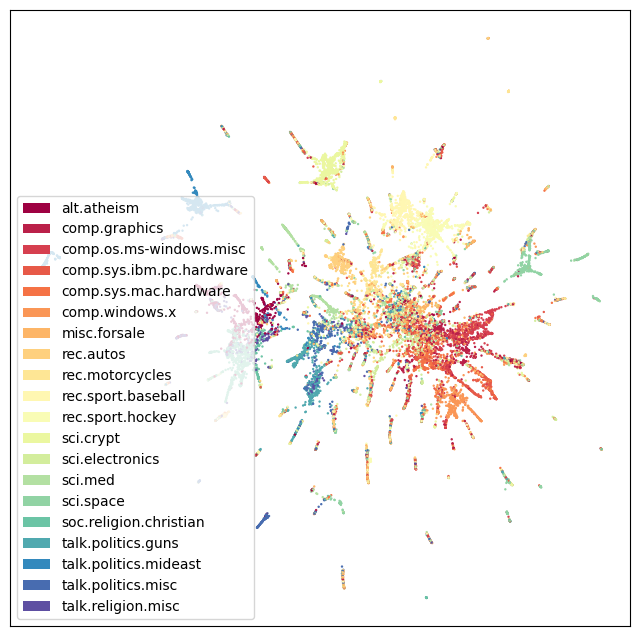

In [12]:
plot_20k_newsgroups(topo_MAP, figsize=(12,12))

As we can see, with TopOMetry it is possible to uncover a rather more elaborate visualization of the data geometry. In this case, a central root of texts containing mostly common words and distributed across many different topics - as we walk away from this homogenous mass in the geometry of this dataset, neighborhood paths become more specific and restrited to single-topics. Plausably, the edges of these spikes should contain the texts with most heterogeneity across the dataset, rendering them good examples for specific language of a specific field. Similarly, words enriched at the central blob could be striped off the dataset for a downstream, more refined analysis containing heterogeneity-driving words.

We do not claim any particular model performs better or worse beforehand - instead, seeing how different algorithms deal with the heterogenous structure of data allows us to elaborate better insights from data. For details, check the evaluation tutorial.